In [1]:
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
csv = pd.read_csv("cleaned_slayer.csv")

In [42]:
csv['file_name'].value_counts()

file_name
0     339
1     338
2     130
3     117
4      88
5      85
6      71
7      45
8      41
9      40
10     38
11     38
12     37
13     37
14     36
15     35
16     35
17     35
18     34
19     31
Name: count, dtype: int64

In [4]:
data_texts = csv['content'].to_list()

data_labels = csv['file_name'].to_list()

In [5]:
#Train Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )


In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

from sklearn.metrics import accuracy_score, precision_score, f1_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=-1)  # Get the index of the highest logit as the predicted class
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        "accuracy": acc,
        "precision": precision,
        "f1": f1
    }

# Model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Custom Dataset class for PyTorch
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Convert to PyTorch Datasets
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Model definition
trainer_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    evaluation_strategy="steps",     
    eval_steps=100                   
)

# Trainer setup
trainer = Trainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



Step,Training Loss,Validation Loss,Accuracy,Precision,F1
100,No log,0.915425,0.269697,0.113353,0.151310
200,No log,0.629339,0.421212,0.301976,0.329891
300,No log,0.575003,0.421212,0.305032,0.330303
400,No log,0.658770,0.427273,0.284557,0.328103
500,0.550100,0.847353,0.415152,0.281724,0.319383


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarnin

TrainOutput(global_step=574, training_loss=0.4972773960658482, metrics={'train_runtime': 2346.8163, 'train_samples_per_second': 3.895, 'train_steps_per_second': 0.245, 'total_flos': 1211081748817920.0, 'train_loss': 0.4972773960658482, 'epoch': 7.0})

In [48]:

trainer.save_model("distilbertfinetune")

In [79]:
test = pd.read_csv("test.csv")

In [80]:
# Convert to numeric with errors='coerce' (turns invalid values into NaN)
test['country'] = pd.to_numeric(test['country'], errors='coerce')

# Drop rows with NaN values (those that couldn't be converted)
test = test.dropna(subset=['country'])



In [81]:
test['country'].value_counts()

country
1.0     517
0.0     114
3.0      34
2.0      13
10.0      1
4.0       1
Name: count, dtype: int64

In [82]:
test_texts = test['text'].to_list()

test_labels = test['country'].to_list()

In [83]:
from transformers import DistilBertTokenizer

# Load the tokenizer used during training
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


In [84]:
class NewTestDataset(Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

# Instantiate dataset
test_dataset = TextDataset(test_encodings, test_labels)


In [85]:
test_results = trainer.predict(test_dataset)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [86]:
metrics = test_results.metrics
print(f"Test Accuracy: {metrics['test_accuracy']}")
print(f"Test F1: {metrics['test_f1']}")
print(f"Test Precision: {metrics['test_precision']}")

Test Accuracy: 0.7558823529411764
Test F1: 0.7686626742281454
Test Precision: 0.7833735596130005


In [8]:
# Evaluate the model on the validation dataset
# Evaluate the model
eval_results = trainer.evaluate()

# Output validation loss and accuracy
validation_loss = eval_results.get("eval_loss", None)
accuracy = eval_results.get("eval_accuracy", None)

print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {accuracy}")



Validation Loss: 0.8993900418281555
Validation Accuracy: 0.4212121212121212


In [36]:
predictions = test_results.predictions.argmax(axis=-1)  # Choose the class with highest probability
true_labels = test_results.label_ids

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Optionally, print or visualize the confusion matrix
print(conf_matrix)

[[ 69  33   6   6   0   0]
 [ 29 437   6  44   1   0]
 [  3   4   2   4   0   0]
 [  2  26   0   6   0   0]
 [  1   0   0   0   0   0]
 [  0   0   0   1   0   0]]


In [87]:
country_codes = ['GB', 'US', 'AU', 'CA', 'IE', 'PH']
number_to_country_code = {index: country for index, country in enumerate(country_codes)}


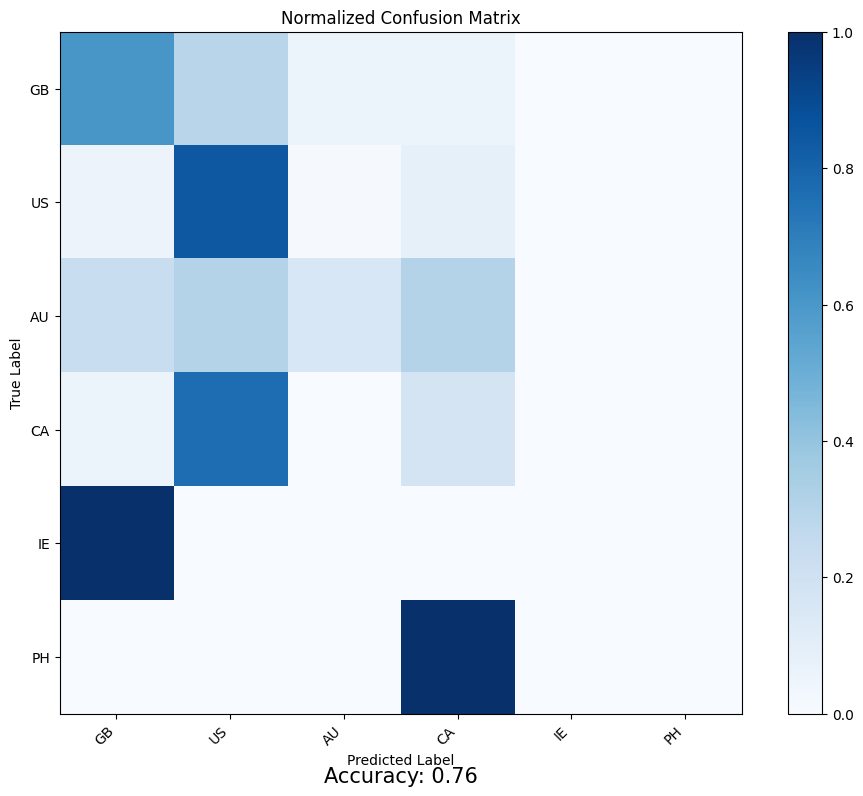

In [88]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# Get the predicted labels and true labels
predictions = test_results.predictions.argmax(axis=-1)  # Choose the class with highest probability
true_labels = test_results.label_ids

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')

# Get class names from your label encoder or dataset
# If you have a label encoder, use it to get the class names:
class_names = [number_to_country_code[i] for i in range(len(country_codes))]

# Create a confusion matrix plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

# Add labels for axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)


# Display overall accuracy
accuracy = (predictions == true_labels).mean()
plt.text(0.5, -0.1, f'Accuracy: {accuracy:.2f}', size=15, ha='center', transform=plt.gca().transAxes)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()



In [73]:
test = pd.read_csv("testcovid.csv")
# Convert to numeric with errors='coerce' (turns invalid values into NaN)
test['country'] = pd.to_numeric(test['country'], errors='coerce')

# Drop rows with NaN values (those that couldn't be converted)
test = test.dropna(subset=['country'])
test_texts = test['text'].to_list()

test_labels = test['country'].to_list()



In [74]:

from transformers import DistilBertTokenizer

# Load the tokenizer used during training
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)
class NewTestDataset(Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

# Instantiate dataset
test_dataset = TextDataset(test_encodings, test_labels)


In [75]:
test_results = trainer.predict(test_dataset)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [76]:
metrics = test_results.metrics
print(f"Test Accuracy: {metrics['test_accuracy']}")
print(f"Test F1: {metrics['test_f1']}")
print(f"Test Precision: {metrics['test_precision']}")

Test Accuracy: 0.5144592952612393
Test F1: 0.4434883454084479
Test Precision: 0.40793645790836736


In [62]:
test['country'].value_counts()

country
1.0     1720
0.0      356
5.0      319
3.0      261
2.0      211
9.0      186
4.0      179
13.0     164
11.0     134
6.0      110
10.0      96
12.0      93
14.0      74
7.0       60
15.0      34
18.0      34
8.0       31
16.0      29
17.0      14
19.0      10
Name: count, dtype: int64

In [77]:

country_codes = ['gb', 'us', 'au', 'ca', 'ie', 'in', 'nz', 'pk', 'lk', 'za', 'ph', 'sg', 'my', 'ng', 'ke', 'bd', 'hk', 'jm', 'gh', 'tz']

# Create a dictionary to map country codes to numbers starting from 0
number_to_country_code = {index: country for index, country in enumerate(country_codes)}

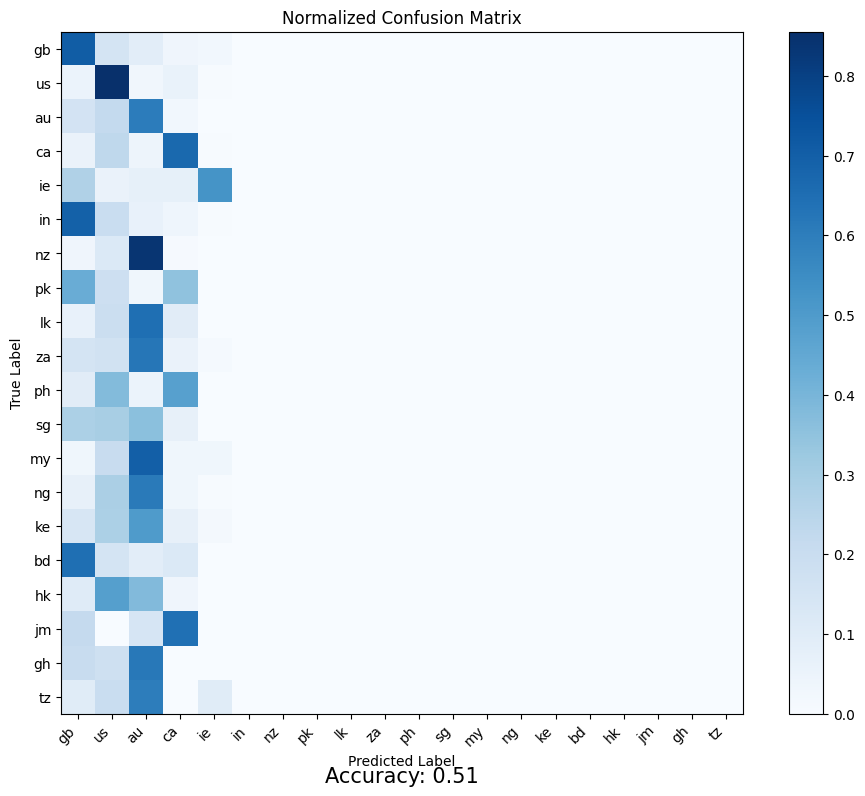

In [78]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# Get the predicted labels and true labels
predictions = test_results.predictions.argmax(axis=-1)  # Choose the class with highest probability
true_labels = test_results.label_ids

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')

# Get class names from your label encoder or dataset
# If you have a label encoder, use it to get the class names:
class_names = [number_to_country_code[i] for i in range(len(country_codes))]

# Create a confusion matrix plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

# Add labels for axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Add annotations for all cells (with accuracy values)


# Display overall accuracy
accuracy = (predictions == true_labels).mean()
plt.text(0.5, -0.1, f'Accuracy: {accuracy:.2f}', size=15, ha='center', transform=plt.gca().transAxes)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()



In [97]:
test = pd.read_csv("testnow.csv")
# Convert to numeric with errors='coerce' (turns invalid values into NaN)
test['country'] = pd.to_numeric(test['country'], errors='coerce')

# Drop rows with NaN values (those that couldn't be converted)
test = test.dropna(subset=['country'])
test_texts = test['text'].to_list()

test_labels = test['country'].to_list()


In [98]:

from transformers import DistilBertTokenizer

# Load the tokenizer used during training
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)
class NewTestDataset(Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

# Instantiate dataset
test_dataset = TextDataset(test_encodings, test_labels)

In [99]:
test_results = trainer.predict(test_dataset)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



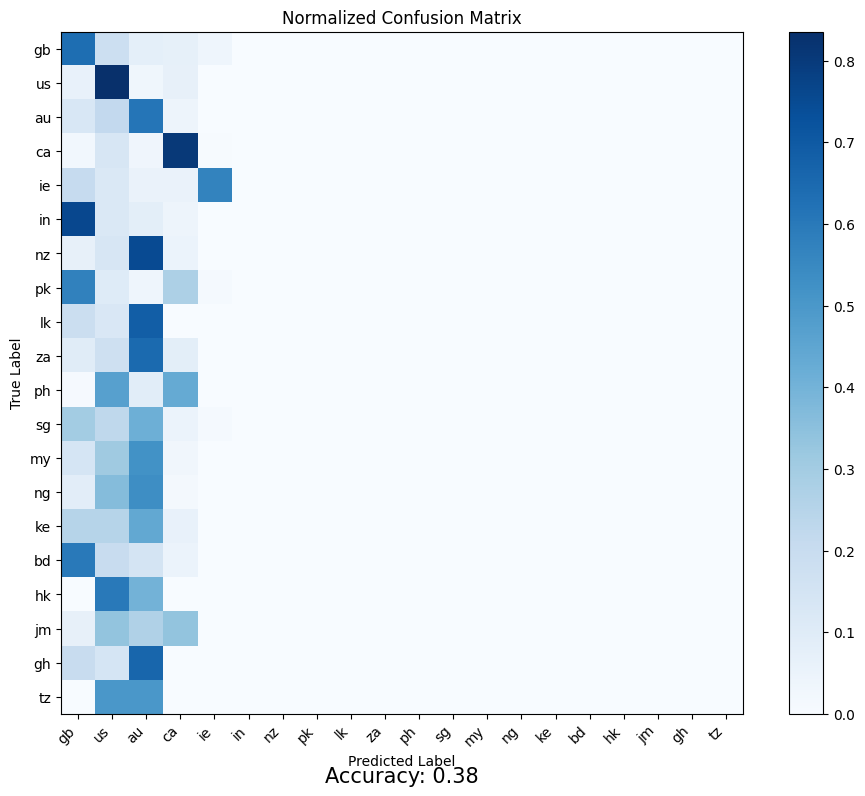

In [71]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# Get the predicted labels and true labels
predictions = test_results.predictions.argmax(axis=-1)  # Choose the class with highest probability
true_labels = test_results.label_ids

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')

# Get class names from your label encoder or dataset
# If you have a label encoder, use it to get the class names:
class_names = [number_to_country_code[i] for i in range(len(country_codes))]

# Create a confusion matrix plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

# Add labels for axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Add annotations for all cells (with accuracy values)
# Display overall accuracy
accuracy = (predictions == true_labels).mean()
plt.text(0.5, -0.1, f'Accuracy: {accuracy:.2f}', size=15, ha='center', transform=plt.gca().transAxes)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()


In [100]:
metrics  = test_results.metrics
print(f"Test Accuracy: {metrics['test_accuracy']}")
print(f"Test F1: {metrics['test_f1']}")
print(f"Test Precision: {metrics['test_precision']}")

Test Accuracy: 0.3795391061452514
Test F1: 0.2886829067140687
Test Precision: 0.25839709945601697
